# Project: Scientific Claim Checking

Set colab environment and make sure you are using GPUs.

Click Edit and Notebook Settings. Then choose GPU as the hardware accelerator

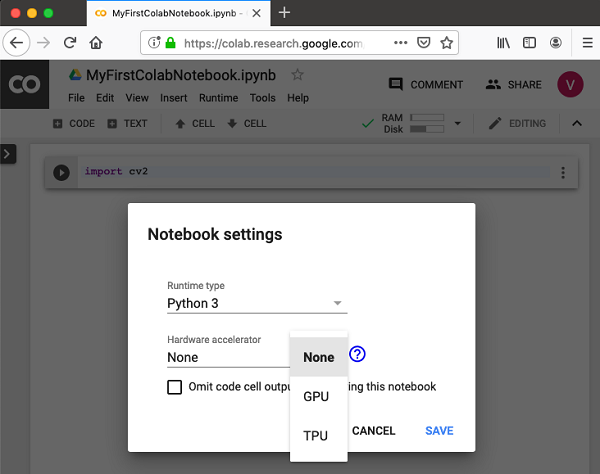

Check if there are GPUs by the command "!nvidia-smi"

In [ ]:
!nvidia-smi

Mon Feb 28 06:48:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download data

Download data from the shared link

In [ ]:
!wget -O /content/train.csv https://www.dropbox.com/s/90z42z12dqd2p2b/train_update.csv?dl=0
!wget -O /content/test_phase_1.csv https://www.dropbox.com/s/9dzmde0ewg2t35l/test_phase_1_update.csv?dl=0

--2022-02-28 05:32:58--  https://www.dropbox.com/s/90z42z12dqd2p2b/train_update.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/90z42z12dqd2p2b/train_update.csv [following]
--2022-02-28 05:32:59--  https://www.dropbox.com/s/raw/90z42z12dqd2p2b/train_update.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8c3abe0c2411a73942739165d6.dl.dropboxusercontent.com/cd/0/inline/BgjenB3m09IY7ThcgDp6rxOxAil1ZTpsgq10KOKC0F9av8sb4wvOdyvgat4wzoPpPVNacZGmIVbhsoZVmbAsZnUvD7nMJwAHcot8_ajjQSfDGTbAZdMlXsMt7wOJWTTuTAvM9ff2mwr0trW5e_XqO0wO/file# [following]
--2022-02-28 05:32:59--  https://uc8c3abe0c2411a73942739165d6.dl.dropboxusercontent.com/cd/0/inline/BgjenB3m09IY7ThcgDp6rxOxAil1ZTpsgq10KOKC0F9av8sb4wvOdyvgat4wzoPpPVNacZ

Check if the datasets have been downloaded sucessfully.

In [ ]:
!ls -lct

total 6024
-rw-r--r-- 1 root root   44891 Feb 28 05:33 test_phase_1.csv
-rw-r--r-- 1 root root  346421 Feb 28 05:33 train.csv
-rw-r--r-- 1 root root 5769039 Feb 28 05:30 nli-model.pt
drwxr-xr-x 1 root root    4096 Feb 24 15:44 sample_data


### Prepare Data

Read data by pandas 

In [ ]:
import pandas as pd

train_df = pd.read_csv('./train.csv') # 1179
test_df = pd.read_csv('./test_phase_1.csv') # 150

Show some data examples in the training and test sets.

In [ ]:
train_df.head(5)

,ID,Claim,Evidence,Label
0,0,Antidepressants increase the severity of migra...,Tricyclics were also more likely to reduce the...,2
1,1,Citrullinated proteins externalized in neutrop...,These observations implicate accelerated NETos...,1
2,2,Recognition of start codons depends on the tra...,IF3 and tRNA undergo large conformational chan...,1
3,3,Ca2+ cycling is a UCP1-dependent thermogenic m...,"Conversely, enhanced Ca2+ cycling by activatio...",2
4,4,Weighed food records (WFR) result in poor comp...,The Hippo pathway controls organ size and tiss...,0


In [ ]:
test_df.head(5)

,ID,Claim,Evidence
0,0,Beta-band coherence is diminished for visible ...,This result suggests that traces of a heavy me...
1,1,Physical activity level is associated with the...,The best diagnostic performance is obtained wh...
2,2,Autologous transplantation of mesenchymal stem...,"After 6 months, 4 of 53 patients (7.5%) in the..."
3,3,RAD52 is involved in break-induced DNA replica...,"At CFSs, this fragility is associated with a d..."
4,4,Human embryonic stem cells give rise to cell t...,Embryonic stem cells have the ability to remai...


Fix a random seed for reproducing results. There are some random operators during the data processing and model initialiation. If we do not fix the random seed, we will get different results every time even though we do the same data processing and model bulding.

In [ ]:
import numpy as np
import torch
import random
#fix seed
seed = 2022
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Prepare training, validation, and test data examples

Note that you should split the training data into the training set and validation set for finding the best model. Here, we treat 10% data examples randomly sampled from the original training data examples as the validation set and the rest as the new training set. (You can change the number of valiation examples)

In [ ]:
train_examples = []
for index, row in train_df.iterrows():
  # print (row)
  claim, evidence, label = row['Claim'], row['Evidence'], row['Label']
  train_examples.append([claim.strip(), evidence.strip(), label])

random.shuffle(train_examples)
valid_num = int(len(train_examples)*0.1)
valid_examples = train_examples[:valid_num]
train_examples = train_examples[valid_num:]

test_examples = []
for index, row in test_df.iterrows():
  # print (row)
  claim, evidence = row['Claim'], row['Evidence']
  test_examples.append([claim.strip(), evidence.strip()])


Prepare vocab dictionary

In [ ]:
vocab_dict = {'[PAD]':0, '[SEP]':1, '[UNK]':2}
vocab_list = ['[PAD]', '[SEP]', '[UNK]']

vocab_p = 2
for row in train_examples:
    row_split = row[0].strip().split()
    for word in row_split:
        if word not in vocab_dict:
            vocab_list.append(word)
            vocab_dict[word] = vocab_p
            vocab_p+=1

    row_split = row[1].strip().split()
    for word in row_split:
        if word not in vocab_dict:
            vocab_list.append(word)
            vocab_dict[word] = vocab_p
            vocab_p += 1

print (f'vocab_dict len: {len(vocab_dict)}')
assert len(vocab_dict) == len(vocab_list)

vocab_dict len: 8833


### Define Dataset Class (Object)

In [ ]:
from torch.utils.data import Dataset

class NLIDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [ ]:
training_data_torch = NLIDataset(train_examples)
valid_data_torch = NLIDataset(valid_examples)
test_data_torch = NLIDataset(test_examples)

Prepare dataloader

Processing function for dataloader

In [ ]:
def batch_process(data, vocab_dict, train_flag=True):
    transposed_data = list(zip(*data))
    input_left = list(transposed_data[0])
    input_right = list(transposed_data[1])

    def process_input(inputs):
        inputs_ = []
        for input in inputs:
            row = input.strip().split() 
            inputs_.append(row)
        max_len = max([len(input) for input in inputs_])  # find the maximum length in this batch of data examples.
        inputs_idx = []
        for input in inputs:
            row =input.strip().split()
            row = (max_len-len(row))*['[PAD]']+row  # Keep all input having the same length
            row_ = []
            for e in row:
                if e not in vocab_dict:
                    row_.append(vocab_dict['[UNK]']) # some words in the test dataset may not appear in the training set.
                else:
                    row_.append(vocab_dict[e])
            inputs_idx.append(row_)
        return inputs_idx

    inputs_left_idx = process_input(input_left)
    inputs_right_idx = process_input(input_right)

    if train_flag:
      labels = list(transposed_data[2])
      return inputs_left_idx, inputs_right_idx, labels
    else:
      return inputs_left_idx, inputs_right_idx # test data examples don't have labels

Get dataloaders

In [ ]:
from torch.utils.data import DataLoader
from functools import partial


# hyper-parameters for data preparing
batch_size = 16


train_dataloader = DataLoader(training_data_torch, collate_fn=partial(batch_process, vocab_dict=vocab_dict, train_flag=True), \
                              batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_torch, collate_fn=partial(batch_process, vocab_dict=vocab_dict,  train_flag=True), \
                             batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data_torch, collate_fn=partial(batch_process, vocab_dict=vocab_dict,  train_flag=False), \
                             batch_size=batch_size, shuffle=False)

### Define Model

Here, we develop a simple baseline model based on LSTM

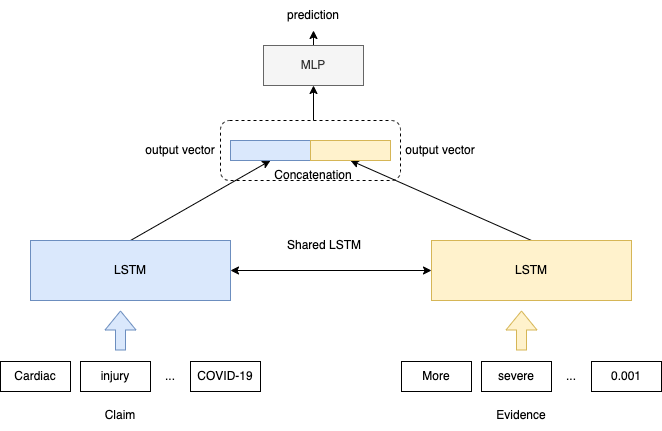

In [ ]:
import torch.nn as nn
class LSTMNLIModel(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, num_layers, label_num, dropout_ratio):
        super(LSTMNLIModel, self).__init__()
        self.embed_size = embed_size  # embedding size of tokens (words)
        self.hidden_size = hidden_size # hidden size of LSTM 
        self.num_layers = num_layers # how many layers of LSTM

        self.embedding = nn.Embedding(num_words, embed_size)
        self.projection = nn.Linear(self.embed_size, self.hidden_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_ratio)

        self.lstm = nn.LSTM(self.hidden_size,self.hidden_size,self.num_layers,bidirectional=False,batch_first=True,dropout=dropout_ratio)
        self.lin = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.nli_head = nn.Linear(self.hidden_size, label_num)

        self.out = nn.Sequential(  
            self.lin,
            self.relu,
            self.dropout,
            self.nli_head
        )

    def forward(self, input_left, input_right):

        input_left_emb = self.embedding(input_left) # claim input (a set of tokens)
        input_right_emb = self.embedding(input_right) # evidence input

        input_left_project_emb = self.relu(self.projection(input_left_emb))
        input_right_project_emb = self.relu(self.projection(input_right_emb))

        left_hidden = self.lstm(input_left_project_emb)[0] # shared lstm encoder for claim representations
        right_hidden = self.lstm(input_right_project_emb)[0] # shared lstm encoder for evidence representations

        fuse_emb = torch.cat([left_hidden[:,-1,:], right_hidden[:,-1,:]], dim=-1) # fuse claim and evidence outputs by the concatenation operator.
   
        output = self.out(fuse_emb) # classifier

        return output


Hyper-parameters for model

Change the embedding size, hidden size, number of layers, and dropout ratios of LSTM. You might get better results.

In [ ]:
embed_size = 128
hidden_size = 128
num_layers = 2
label_num = 3
dropout_ratio = 0.2

In [ ]:
model = LSTMNLIModel(
    num_words=len(vocab_dict),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    label_num=label_num,
    dropout_ratio=dropout_ratio
)

In [ ]:
print (model)

LSTMNLIModel(
  (embedding): Embedding(8833, 128)
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (lin): Linear(in_features=256, out_features=128, bias=True)
  (nli_head): Linear(in_features=128, out_features=3, bias=True)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


### Training

Utils

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Hyper-parameters for training

In [ ]:
N_EPOCHS = 20
device = 'cuda'
lr = 1e-3

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)


Evaluation Metrics

In [ ]:
from sklearn.metrics import f1_score

def macro_f1(pred, y):
    return f1_score(pred, y, average='macro')

def compute_accuracy(pred, y):
    correct = (np.array(pred) == np.array(y)).astype(float)
    acc = correct.sum() / len(correct)
    return acc

Training, validation, and test function each epoch.

In [ ]:
from tqdm import tqdm

def iteration_func(model, iterator, optimizer=None, criterion=None, flag='Train'):
    epoch_loss = 0

    if flag == 'Train':
      model.train()
    else:
      model.eval()
    preds = []
    ys = []

    with tqdm(total=len(iterator)) as pbar:
        for batch in iterator:
            if flag == 'Train':
              optimizer.zero_grad()

            if flag == 'Test':
              feature_left, feature_right = batch
            else:
              feature_left, feature_right, labels = batch

            feature_left = torch.LongTensor(feature_left).to(device)
            feature_right = torch.LongTensor(feature_right).to(device)
            if flag != 'Test':
              labels = torch.LongTensor(labels).to(device)

            logits = model(feature_left, feature_right)

            if flag != 'Test':
              loss = criterion(logits, labels)

            preds.extend(logits.argmax(-1).detach().cpu().numpy())

            if flag != 'Test':
              ys.extend(labels.detach().cpu().numpy())

            if flag == 'Train':
              loss.backward()
              optimizer.step()

            if flag != 'Test':
              epoch_loss += loss.item()

            pbar.update(1)

    if flag != 'Test':
      ma_f1 = macro_f1(preds, ys)
      epoch_acc = compute_accuracy(preds, ys)

      return epoch_loss / len(iterator), epoch_acc, ma_f1, preds# / len(iterator)
    else:
      return preds

Main function

In [ ]:
import time 

best_valid_performance = -float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1, _ = iteration_func(model, train_dataloader, optimizer, criterion, flag='Train')

    valid_loss, valid_acc, valid_f1, valid_preds = iteration_func(model, valid_dataloader, optimizer=None, criterion = criterion, flag='Valid')
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%  |  Train Macro F1: {train_f1 * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%  |  Val. Macro F1: {valid_f1 * 100:.2f}%')

    if (valid_acc+valid_f1)/2. > best_valid_performance: # choose the best model in terms of 50% acc + 50% f1 of validation
        best_valid_performance = (valid_acc+valid_f1)/2.
        torch.save(model.state_dict(), 'nli-model.pt')  # save the best model
        print(f'\t Best Val. Loss: {valid_loss:.3f} |  Best Val. Acc: {valid_acc * 100:.2f}%  |  Best Val. Macro F1: {valid_f1 * 100:.2f}%')


100%|██████████| 8/8 [00:00<00:00, 80.61it/s]


	 Best Val. Loss: 1.035 |  Best Val. Acc: 48.72%  |  Best Val. Macro F1: 21.84%
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.046 | Train Acc: 49.91%  |  Train Macro F1: 23.29%
	 Val. Loss: 1.035 |  Val. Acc: 48.72%  |  Val. Macro F1: 21.84%


100%|██████████| 8/8 [00:00<00:00, 87.64it/s]


	 Best Val. Loss: 0.972 |  Best Val. Acc: 52.99%  |  Best Val. Macro F1: 36.14%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.995 | Train Acc: 51.60%  |  Train Macro F1: 25.76%
	 Val. Loss: 0.972 |  Val. Acc: 52.99%  |  Val. Macro F1: 36.14%


100%|██████████| 8/8 [00:00<00:00, 95.78it/s]


Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.831 | Train Acc: 60.83%  |  Train Macro F1: 53.07%
	 Val. Loss: 1.010 |  Val. Acc: 48.72%  |  Val. Macro F1: 35.37%


100%|██████████| 8/8 [00:00<00:00, 64.90it/s]


	 Best Val. Loss: 0.887 |  Best Val. Acc: 61.54%  |  Best Val. Macro F1: 56.47%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.620 | Train Acc: 72.60%  |  Train Macro F1: 68.34%
	 Val. Loss: 0.887 |  Val. Acc: 61.54%  |  Val. Macro F1: 56.47%


100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


	 Best Val. Loss: 0.958 |  Best Val. Acc: 64.10%  |  Best Val. Macro F1: 61.53%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.432 | Train Acc: 83.15%  |  Train Macro F1: 81.34%
	 Val. Loss: 0.958 |  Val. Acc: 64.10%  |  Val. Macro F1: 61.53%


100%|██████████| 8/8 [00:00<00:00, 97.65it/s]


Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.299 | Train Acc: 88.23%  |  Train Macro F1: 87.34%
	 Val. Loss: 0.985 |  Val. Acc: 63.25%  |  Val. Macro F1: 58.96%


100%|██████████| 8/8 [00:00<00:00, 92.77it/s]


	 Best Val. Loss: 1.416 |  Best Val. Acc: 64.96%  |  Best Val. Macro F1: 62.16%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.219 | Train Acc: 92.00%  |  Train Macro F1: 91.65%
	 Val. Loss: 1.416 |  Val. Acc: 64.96%  |  Val. Macro F1: 62.16%


100%|██████████| 8/8 [00:00<00:00, 106.41it/s]


Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.145 | Train Acc: 93.88%  |  Train Macro F1: 94.07%
	 Val. Loss: 1.389 |  Val. Acc: 64.96%  |  Val. Macro F1: 61.29%


100%|██████████| 8/8 [00:00<00:00, 97.35it/s]


	 Best Val. Loss: 1.310 |  Best Val. Acc: 67.52%  |  Best Val. Macro F1: 65.39%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.155 | Train Acc: 94.07%  |  Train Macro F1: 94.16%
	 Val. Loss: 1.310 |  Val. Acc: 67.52%  |  Val. Macro F1: 65.39%


100%|██████████| 8/8 [00:00<00:00, 105.13it/s]


Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.119 | Train Acc: 95.48%  |  Train Macro F1: 95.71%
	 Val. Loss: 1.493 |  Val. Acc: 65.81%  |  Val. Macro F1: 62.65%


100%|██████████| 8/8 [00:00<00:00, 105.89it/s]


Epoch: 11 | Epoch Time: 0m 2s
	Train Loss: 0.075 | Train Acc: 96.52%  |  Train Macro F1: 96.54%
	 Val. Loss: 1.815 |  Val. Acc: 67.52%  |  Val. Macro F1: 63.76%


100%|██████████| 8/8 [00:00<00:00, 91.33it/s]


Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.096 | Train Acc: 95.20%  |  Train Macro F1: 95.33%
	 Val. Loss: 1.464 |  Val. Acc: 66.67%  |  Val. Macro F1: 62.29%


100%|██████████| 8/8 [00:00<00:00, 65.30it/s]


	 Best Val. Loss: 1.640 |  Best Val. Acc: 68.38%  |  Best Val. Macro F1: 64.83%
Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 0.071 | Train Acc: 96.80%  |  Train Macro F1: 96.93%
	 Val. Loss: 1.640 |  Val. Acc: 68.38%  |  Val. Macro F1: 64.83%


100%|██████████| 8/8 [00:00<00:00, 98.96it/s]


	 Best Val. Loss: 1.820 |  Best Val. Acc: 70.09%  |  Best Val. Macro F1: 66.93%
Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.087 | Train Acc: 96.52%  |  Train Macro F1: 96.60%
	 Val. Loss: 1.820 |  Val. Acc: 70.09%  |  Val. Macro F1: 66.93%


100%|██████████| 8/8 [00:00<00:00, 86.07it/s]


	 Best Val. Loss: 1.739 |  Best Val. Acc: 71.79%  |  Best Val. Macro F1: 69.39%
Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 0.045 | Train Acc: 97.46%  |  Train Macro F1: 97.61%
	 Val. Loss: 1.739 |  Val. Acc: 71.79%  |  Val. Macro F1: 69.39%


100%|██████████| 8/8 [00:00<00:00, 54.05it/s]


Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.058 | Train Acc: 97.93%  |  Train Macro F1: 98.03%
	 Val. Loss: 1.675 |  Val. Acc: 70.94%  |  Val. Macro F1: 68.03%


100%|██████████| 8/8 [00:00<00:00, 70.05it/s]


	 Best Val. Loss: 1.760 |  Best Val. Acc: 75.21%  |  Best Val. Macro F1: 72.85%
Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 0.048 | Train Acc: 97.46%  |  Train Macro F1: 97.51%
	 Val. Loss: 1.760 |  Val. Acc: 75.21%  |  Val. Macro F1: 72.85%


100%|██████████| 8/8 [00:00<00:00, 100.12it/s]


Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.038 | Train Acc: 97.93%  |  Train Macro F1: 98.05%
	 Val. Loss: 1.584 |  Val. Acc: 70.94%  |  Val. Macro F1: 68.46%


100%|██████████| 8/8 [00:00<00:00, 106.60it/s]


Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 0.029 | Train Acc: 97.83%  |  Train Macro F1: 97.86%
	 Val. Loss: 2.016 |  Val. Acc: 70.94%  |  Val. Macro F1: 66.39%


100%|██████████| 8/8 [00:00<00:00, 102.50it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.044 | Train Acc: 97.83%  |  Train Macro F1: 97.87%
	 Val. Loss: 2.024 |  Val. Acc: 68.38%  |  Val. Macro F1: 65.22%


### Testing

In [ ]:
model.load_state_dict(torch.load('nli-model.pt'))
model.eval()

LSTMNLIModel(
  (embedding): Embedding(8833, 128)
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (lin): Linear(in_features=256, out_features=128, bias=True)
  (nli_head): Linear(in_features=128, out_features=3, bias=True)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
test_preds = iteration_func(model, test_dataloader,  optimizer=None, criterion = None, flag='Test')

100%|██████████| 10/10 [00:00<00:00, 89.03it/s]


Print the predictions of the test data examples

In [ ]:
for elem in test_preds:
  print (elem)

0
2
2
1
1
1
1
0
2
1
1
1
1
2
1
1
1
1
0
1
1
1
2
1
1
2
1
1
1
1
1
2
0
2
1
0
1
1
1
1
1
1
1
2
1
1
1
0
0
1
1
1
1
1
2
1
1
1
1
1
0
1
1
2
2
1
0
0
2
0
1
1
0
2
1
1
1
2
2
1
2
2
1
1
1
2
1
1
1
1
2
0
0
2
1
2
1
1
1
1
2
0
1
1
1
1
1
2
1
1
0
0
1
1
2
2
1
2
1
1
2
1
1
1
1
2
1
1
1
2
1
2
1
1
1
2
1
1
0
1
2
0
1
0
2
0
1
0
0
1


### Prepare Submission Files

- Copy the above results and paste them into a submission file in your own pc desktop, like "sub.txt"
- Compress the file as a zip file, like "sub.txt.zip"
- submit your file to the competition website. 
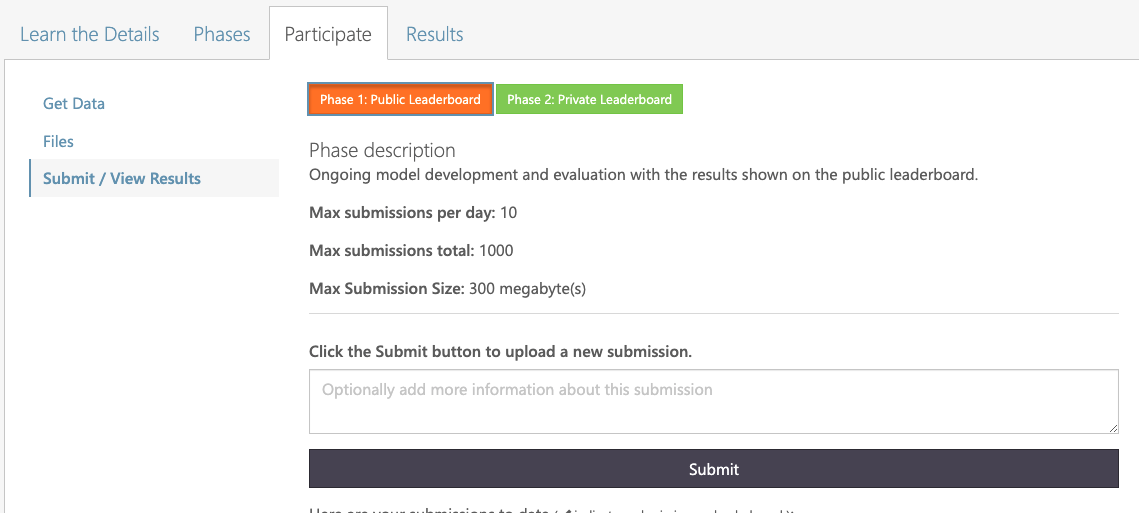

This simple baseline based on LSTM will help you get around 0.54 scores. Please try more models and strategies to beat a stronger baseline with 0.73 scores.

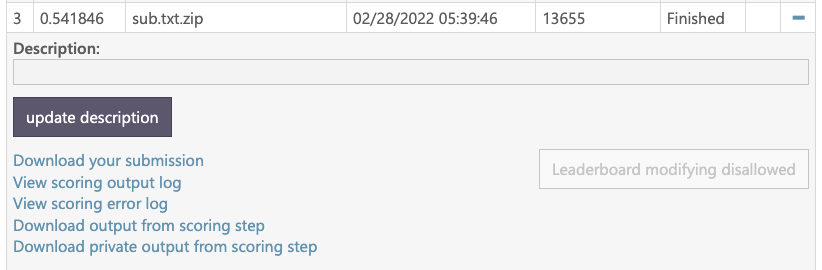